**Task I - simple quantum circuit and operations**



**Part 1**
*   With 5 qubits 
*   Apply Hadamard operation on every qubit 
*   Apply CNOT operation on (0, 1), (1,2), (2,3), (3,4) 
*   SWAP (0, 4) 
*   Rotate X with pi/2 on any qubit 
*   Plot the circuit 



In [ ]:
!pip install pennylane

In [ ]:
!pip install torch_geometric

In [ ]:
!pip install lightning

In [ ]:
import torch
import numpy as np
import pennylane as qml

n_qubits = 5 # (4 normal qubits + 1 ancilla)

# here we begin part a), where we create a quantum device for 5 qubits.
dev = qml.device("default.qubit", wires=n_qubits)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
def H_layer(nqubits):
    """Layer of single-qubit Hadamard gates.
    """
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)

In [ ]:
@qml.qnode(dev, interface="torch")
def pqc_exercise_1(rx_angle):#(q_input_features, q_weights_flat):
    """
    b) Apply Hadamard operation on every qubit 
    c) Apply CNOT operation on (0, 1), (1,2), (2,3), (3,4) 
    d) SWAP (0, 4) 
    e) Rotate X with pi/2 on any qubit 

    """

    # Apply Hadamard operation on every qubit 
    H_layer(n_qubits)

    # Apply CNOT operation on (0, 1), (1,2), (2,3), (3,4) 
    for i in range(0, n_qubits - 1):  
        qml.CNOT(wires=[i, i + 1])

    # SWAP between first and fifth qubit.
    qml.SWAP([0,4])

    # Rotate over X on 0
    qml.RX(rx_angle, wires=0)

    # Expectation values in the Z basis
    exp_vals = [qml.expval(qml.PauliZ(position)) for position in range(n_qubits)]
    return tuple(exp_vals)

In [ ]:
print(qml.draw(pqc_exercise_1)(rx_angle = np.pi/2))

0: ──H─╭●──────────╭SWAP──RX(1.57)─┤  <Z>
1: ──H─╰X─╭●───────│───────────────┤  <Z>
2: ──H────╰X─╭●────│───────────────┤  <Z>
3: ──H───────╰X─╭●─│───────────────┤  <Z>
4: ──H──────────╰X─╰SWAP───────────┤  <Z>


**Part 2**

In [ ]:
dev = qml.device("default.qubit", wires=6)

@qml.qnode(dev, interface="torch")
def pqc_exercise_2(rx_angle):
    """
    a) Apply a Hadmard gate to the first qubit
    b) rotate the second qubit by pi/3 around X
    c) Apply Hadamard gate to the third and fourth qubit
    d) Perform a swap test between the states of the first and second qubit |q1 q2> and the third and fourth qubit |q3 q4>

    """

    # Reshape weights
    # q_weights = q_weights_flat.reshape(q_depth, n_qubits)

    # Apply Hadamard operation on the first qubit 
    qml.Hadamard(wires=2)

    # Embed features in the quantum node
    qml.RX(rx_angle, wires=3)

    # Apply Hadamard operation on the third and fourth qubit 
    qml.Hadamard(wires=4)
    qml.Hadamard(wires=5)

    # SWAP test: 1st and 2nd qubit in |+>
    qml.Hadamard(wires=0)
    qml.Hadamard(wires=1)

    # SWAP test between |q1 q2> and |q3 q4>
    qml.CSWAP(wires=[0, 2, 3])
    qml.CSWAP(wires=[1, 4, 5])

    qml.Hadamard(wires=0)
    qml.Hadamard(wires=1)

    exp = [qml.expval(qml.PauliZ(0)), qml.expval(qml.PauliZ(1))] # expected value of ancilla qubit (0-th qubit)
    
    return tuple(exp)

In [ ]:
pqc_exercise_2(np.pi/3)

tensor([0.5000, 1.0000], dtype=torch.float64)

In [ ]:
print(qml.draw(pqc_exercise_2)(rx_angle = np.pi/3))

0: ──H────────╭●─────H───────┤  <Z>
1: ──H────────│─────╭●─────H─┤  <Z>
2: ──H────────├SWAP─│────────┤     
3: ──RX(1.05)─╰SWAP─│────────┤     
4: ──H──────────────├SWAP────┤     
5: ──H──────────────╰SWAP────┤     


**Task II - Classical GNN for quark/gluon dataset**

**Architecture 1**: using the graph neural network operator from the “Weisfeiler and Leman Go Neural: Higher-order Graph Neural Networks” paper [https://arxiv.org/abs/1810.02244]

**Architecture 2**: using the classical graph attentional operator from the “Graph Attention Networks” paper [https://arxiv.org/abs/1710.10903]

In [1]:
import numpy as np

data = np.load('QG_jets.npz')

In [ ]:
print(dict(data).keys())  

dict_keys(['X', 'y'])


I will treat this as a **graph-level prediction task**. Given the dataset description, I thought the following:



*   **Nodes**: each node is represented by one feature vector: pt, rapidity, azimuthal angle, and pdgid. These are the features exactly described in the site. Nodes will be connected by an edge index.
*   **Graph**: as the final prediction task, which is at graph-level, we will consider that there is a "master" node connected to all other nodes in the graph. This is the node that will go through an MLP in the end for classification. 





In [136]:
data['X'].shape

(100000, 139, 4)

In [ ]:
data['y'].shape

(100000,)

### The dataset makes this colab run out of memory, so I will take just a small sample of 15 graphs, 5 for learning/validating/testing respectively.

In [7]:
idx_list = data['y'][np.random.choice(len(data['y']), 15)]

In [10]:
import torch
import itertools
import numpy as np

from tqdm import tqdm
from torch_geometric.data import Data

data_list = []
all_edges = np.array([], dtype=np.int32).reshape((0, 2))
permutations = list(itertools.combinations([i for i in range(139)], 2))

for idx in tqdm(idx_list):
    edges_source = [e[0] for e in permutations]
    edges_target = [e[1] for e in permutations]
    team_edges = np.column_stack([edges_source, edges_target])
    all_edges = np.vstack([all_edges, team_edges])

    edge_index = all_edges.transpose()
    edge_index = torch.from_numpy(edge_index)

    graph_data = Data(x=torch.from_numpy(data['X'][int(idx)]).type(torch.float32), edge_index=edge_index, y=torch.from_numpy(np.array([0])))
    data_list.append(graph_data)



100%|██████████| 15/15 [00:33<00:00,  2.23s/it]


In [11]:
from torch_geometric.loader import DataLoader
graph_train_loader = DataLoader(data_list[:5], batch_size=32, shuffle=True)
graph_val_loader = DataLoader(data_list[5:10], batch_size=32)
graph_test_loader = DataLoader(data_list[10:15], batch_size=32)

As described in the site, the shape of the features is (B, M, N), where **B** represents the number of graphs (or jets), **M** is described as the maximum multiplicity of the jets, and in our case, we'll think of these as the maximum number of nodes in our graph. Finally, **N** is the initial dimension of our node feature vectors.

In [17]:
import lightning as pl
import torch.nn as nn
import torch_geometric
import torch_geometric.nn as geom_nn
import torch_geometric.data as geom_data


gnn_layer_by_name = {
    "GCN": geom_nn.GCNConv,
    "GAT": geom_nn.GATConv,
    "GraphConv": geom_nn.GraphConv
}

class GNNModel(nn.Module):

    def __init__(self, c_in, c_hidden, c_out, num_layers=2, layer_name="GCN", dp_rate=0.1, **kwargs):
        """
        Inputs:
            c_in - Dimension of input features
            c_hidden - Dimension of hidden features
            c_out - Dimension of the output features. Usually number of classes in classification
            num_layers - Number of "hidden" graph layers
            layer_name - String of the graph layer to use
            dp_rate - Dropout rate to apply throughout the network
            kwargs - Additional arguments for the graph layer (e.g. number of heads for GAT)
        """
        super().__init__()
        gnn_layer = gnn_layer_by_name[layer_name]

        layers = []
        in_channels, out_channels = c_in, c_hidden
        for l_idx in range(num_layers-1):
            layers += [
                gnn_layer(in_channels=in_channels,
                          out_channels=out_channels,
                          **kwargs),
                nn.ReLU(inplace=True),
                nn.Dropout(dp_rate)
            ]
            in_channels = c_hidden
        layers += [gnn_layer(in_channels=in_channels,
                             out_channels=c_out,
                             **kwargs)]
        self.layers = nn.ModuleList(layers)

    def forward(self, x, edge_index):
        """
        Inputs:
            x - Input features per node
            edge_index - List of vertex index pairs representing the edges in the graph (PyTorch geometric notation)
        """
        for l in self.layers:
            # For graph layers, we need to add the "edge_index" tensor as additional input
            # All PyTorch Geometric graph layer inherit the class "MessagePassing", hence
            # we can simply check the class type.
            if isinstance(l, geom_nn.MessagePassing):
                x = l(x, edge_index)
            else:
                x = l(x)
        return x

In [19]:
from torch import nn

class GraphGNNModel(nn.Module):

    def __init__(self, c_in, c_hidden, c_out, dp_rate_linear=0.5, **kwargs):
        """
        Inputs:
            c_in - Dimension of input features
            c_hidden - Dimension of hidden features
            c_out - Dimension of output features (usually number of classes)
            dp_rate_linear - Dropout rate before the linear layer (usually much higher than inside the GNN)
            kwargs - Additional arguments for the GNNModel object
        """
        super().__init__()
        self.GNN = GNNModel(c_in=c_in,
                            c_hidden=c_hidden,
                            c_out=c_hidden, # Not our prediction output yet!
                            **kwargs)
        self.head = nn.Sequential(
            nn.Dropout(dp_rate_linear),
            nn.Linear(c_hidden, c_out)
        )

    def forward(self, x, edge_index, batch_idx):
        """
        Inputs:
            x - Input features per node
            edge_index - List of vertex index pairs representing the edges in the graph (PyTorch geometric notation)
            batch_idx - Index of batch element for each node
        """
        x = self.GNN(x, edge_index)
        x = geom_nn.global_mean_pool(x, batch_idx) # Average pooling
        x = self.head(x)
        return x

In [20]:
## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

class GraphLevelGNN(pl.LightningModule):

    def __init__(self, **model_kwargs):
        super().__init__()
        # Saving hyperparameters
        self.save_hyperparameters()

        self.model = GraphGNNModel(**model_kwargs)
        self.loss_module = nn.BCEWithLogitsLoss() if self.hparams.c_out == 1 else nn.CrossEntropyLoss()

    def forward(self, data, mode="train"):
        x, edge_index, batch_idx = data.x, data.edge_index, data.batch
        x = self.model(x, edge_index, batch_idx)
        x = x.squeeze(dim=-1)

        if self.hparams.c_out == 1:
            preds = (x > 0).float()
            data.y = data.y.float()
        else:
            preds = x.argmax(dim=-1)
        loss = self.loss_module(x, data.y)
        acc = (preds == data.y).sum().float() / preds.shape[0]
        return loss, acc

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=1e-2, weight_decay=0.0) # High lr because of small dataset and small model
        return optimizer

    def training_step(self, batch, batch_idx):
        loss, acc = self.forward(batch, mode="train")
        self.log('train_loss', loss)
        self.log('train_acc', acc)
        return loss

    def validation_step(self, batch, batch_idx):
        _, acc = self.forward(batch, mode="val")
        self.log('val_acc', acc)

    def test_step(self, batch, batch_idx):
        _, acc = self.forward(batch, mode="test")
        self.log('test_acc', acc)

In [21]:
def train_graph_classifier(model_name, **model_kwargs):
    pl.seed_everything(42)
    device = "cpu"
    
    trainer = pl.Trainer(default_root_dir=".",
                        #  callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc")],
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         max_epochs=10,
                         enable_progress_bar=False)
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need
    pl.seed_everything(42)
    model = GraphLevelGNN(c_in=4,
                            c_out=1, **model_kwargs) 
    trainer.fit(model, graph_train_loader, graph_val_loader)
    model = GraphLevelGNN.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)
    # Test best model on validation and test set
    train_result = trainer.test(model, graph_train_loader, verbose=False)
    test_result = trainer.test(model, graph_test_loader, verbose=False)
    result = {"test": test_result[0]['test_acc'], "train": train_result[0]['test_acc']}
    return model, result

In [22]:
model, result = train_graph_classifier(model_name="GraphConv",
                                       c_hidden=256,
                                       layer_name="GraphConv",
                                       num_layers=3,
                                       dp_rate_linear=0.5,
                                       dp_rate=0.0)

INFO: Global seed set to 42
INFO:lightning.fabric.utilities.seed:Global seed set to 42
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Global seed set to 42
INFO:lightning.fabric.utilities.seed:Global seed set to 42
INFO: 
  | Name        | Type              | Params
--------------------------------------------------
0 | model       | GraphGNNModel     | 265 K 
1 | loss_module | BCEWithLogitsLoss | 0     
--------------------------------------------------
265 K     Trainable params
0         Non-trainable params
265 K     Total params
1.061     T

In [23]:
print(f"Train performance: {100.0*result['train']:4.2f}%")
print(f"Test performance:  {100.0*result['test']:4.2f}%")

Train performance: 100.00%
Test performance:  100.00%


In [24]:
model, result = train_graph_classifier(model_name="GAT",
                                       c_hidden=256,
                                       layer_name="GAT",
                                       num_layers=3,
                                       dp_rate_linear=0.5,
                                       dp_rate=0.0)

INFO: Global seed set to 42
INFO:lightning.fabric.utilities.seed:Global seed set to 42
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Global seed set to 42
INFO:lightning.fabric.utilities.seed:Global seed set to 42
INFO: 
  | Name        | Type              | Params
--------------------------------------------------
0 | model       | GraphGNNModel     | 134 K 
1 | loss_module | BCEWithLogitsLoss | 0     
--------------------------------------------------
134 K     Trainable params
0         Non-trainable params
134 K     Total params
0.539     T

In [25]:
print(f"Train performance: {100.0*result['train']:4.2f}%")
print(f"Test performance:  {100.0*result['test']:4.2f}%")

Train performance: 100.00%
Test performance:  100.00%


### Discussion: the performance was excelent, but the number of graphs was small due to memory restrictions in this free colab. Nevertheless, I will use the first graph attentional operator in the Quantum GNN to develop a **Quantum Attention Mechanism**.

**Task III - comments about Quantum Computing & Quantum Machine Learning**

Recently, what was before called science fiction (**AI**, and now **Quantum Computing** too), has now opened doors for a new reality: a world where what first started with Rosenblatt's first *Perceptron* and did not have much attention for quite a long time, even from researchers in the field, during the famous AI winter, has now evolved to amazing levels that we have all seen, for example, the Large Language Models, like GPT-4. Even 11 years ago, going back to 2012, the Higgs Boson discovery was only possible through the help of Machine Learning models that helped selecting the true signals generated inside the Large Hadron Collider (LHC). However, when Statistical Learning & Machine Learning Theory first started, it was long before we could see these amazing advancements in the field, reaching the levels we have today. And now, it is extremely exciting that we are witnessing the same with Quantum Computing & Quantum Machine Learning. Although it might take some time to see big applications like the aforementioned, there is one key concept that we should bare in mind: everything starts with a heavy theoretical foundation of basic principles, and this is exactly what the scientists are doing right now; error detection and mitigation, decoherence, these are all fundamental topics that have to be improved before we can see models working with a large number of qubits.

The idea of leveraging how nature works at very small scales to perform complex computations, as once proposed by Richard Feynman - although only a vague discussion at that time - is just outstanding. One example in quantum ML is that we can now encode classical information in a Hilbert space by using the so-called quantum bits (qubits). Along with these novelties, however, questions arise; one is on whether we can achieve a better topological separation in this space, one that allows for better classification of the quantum ML models compared to classical ones. Other speculated advantages are related to speedups; for example, in Quantum Kernel Estimation, one active area of research is on whether we can find kernels that are intractable classically, but easily incorporated in a quantum computer: the DLOG kernel, although it does not have much practical use, is one very famous example. More generally, the big question is this: what types of problems/data will really exhibit better performance on quantum hardware?

In my Machine Learning journey so far, I have worked a lot with Natural Language Processing (NLP) in the industry, and with Quantum Computing in the academia, with a focus on equivariant models - very similar to the task proposed here: I'm working on an Equivariant QCNN. My favorite framework is Pennylane for its intuitive use. So, given my background, I could work on Equivariant PQCs, or Quantum Transformer models for HEP. One theme that I have also worked with, is classical multimodal contrastive learning in the industry - I used OpenAI CLIP's model for similar question recommendation in Education; so, this could be another possible topic. These are my main preferences, but I'm open to any project!

**Task IV - Quantum GANS for HEP**

## In a separate notebook attached in the e-mail!

# **Task V: Quantum Graph Neural Network (QGNN)**

# My proposed approach :


*   Modify the Graph Attention operation to encapsulate it with a PQC. After  a linear projection to the number of qubits, the pair of hidden representation of each node in the pair will be encoded in a PQC. Afterwards, this is input to a single neuron, that outputs a softargmax probability. The downside is that is demands a very high time complexity as the number of heads grow, since self-attention is unstable with a small number of heads.

# First idea: a **Quantum Attention Mechanism**

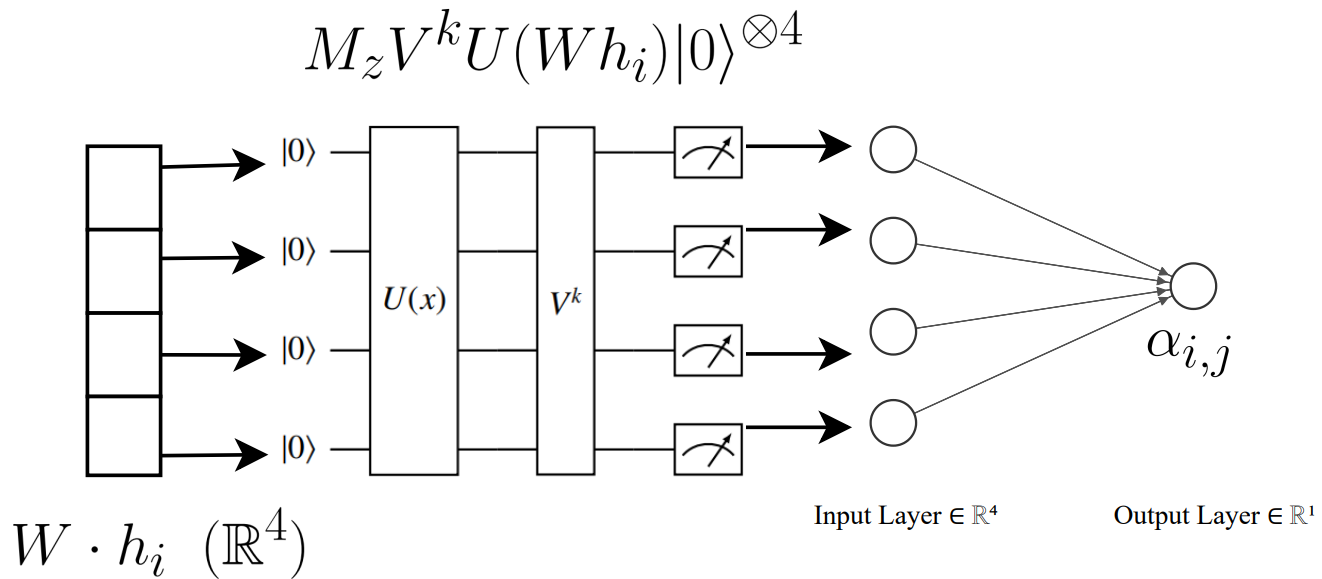

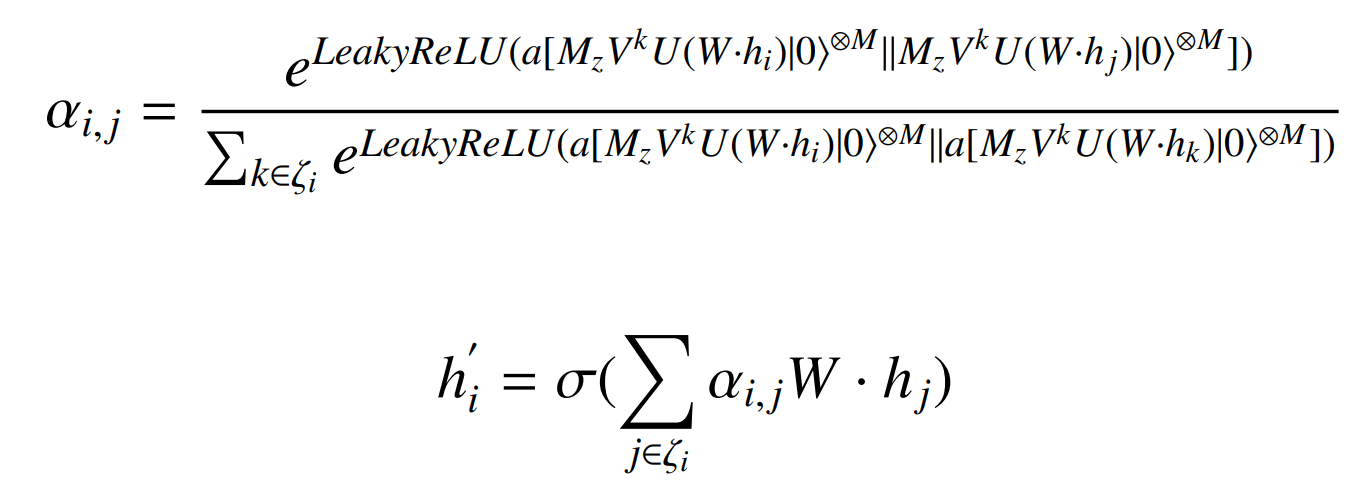

In [5]:
import torch
import pennylane as qml
import torch.nn.functional as F
from torch import nn
from torch_geometric.utils import to_dense_adj


dev = qml.device('default.qubit', wires=4)


def H_layer(nqubits):
    """Layer of single-qubit Hadamard gates.
    """
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)


def RY_layer(w):
    """Layer of parametrized qubit rotations around the y axis.
    """
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)


def entangling_layer(nqubits):
    """Layer of CNOTs followed by another shifted layer of CNOT.
    """
    # In other words it should apply something like :
    # CNOT  CNOT  CNOT  CNOT...  CNOT
    #   CNOT  CNOT  CNOT...  CNOT
    for i in range(0, nqubits - 1, 2):  # Loop over even indices: i=0,2,...N-2
        qml.CNOT(wires=[i, i + 1])
    for i in range(1, nqubits - 1, 2):  # Loop over odd indices:  i=1,3,...N-3
        qml.CNOT(wires=[i, i + 1])


@qml.qnode(dev, interface="torch")
def quantum_net(q_input_features, q_weights_flat, q_depth, n_qubits):
    """
    The variational quantum circuit.
    """

    # Reshape weights
    q_weights = q_weights_flat.reshape(q_depth, n_qubits)

    # Start from state |+> , unbiased w.r.t. |0> and |1>
    H_layer(n_qubits)

    # Embed features in the quantum node
    RY_layer(q_input_features)

    # Sequence of trainable variational layers
    for k in range(q_depth):
        entangling_layer(n_qubits)
        RY_layer(q_weights[k])

    # Expectation values in the Z basis
    exp_vals = [qml.expval(qml.PauliZ(position)) for position in range(n_qubits)]
    return tuple(exp_vals)


class DressedQuantumNet(nn.Module):
    """
    Torch module implementing the *dressed* quantum net.
    """

    def __init__(self, n_qubits, q_depth = 1, q_delta=0.001):
        """
        Definition of the *dressed* layout.
        """

        super().__init__()
        self.n_qubits = n_qubits
        self.q_depth = q_depth
        self.q_params = nn.Parameter(q_delta * torch.randn(q_depth * n_qubits))

    def forward(self, input_features):
        """
        Defining how tensors are supposed to move through the *dressed* quantum
        net.
        """

        # Quantum Embedding (U(X))
        q_in = torch.tanh(input_features) * np.pi / 2.0

        # Apply the quantum circuit to each element of the batch and append to q_out
        q_out = torch.Tensor(0, self.n_qubits)
        q_out = q_out.to(device)
        for batch in q_in:
            for elem in batch:
                q_out_elem = quantum_net(elem, self.q_params, self.q_depth, self.n_qubits).float().unsqueeze(0)
                q_out = torch.cat((q_out, q_out_elem))

        # return the batch measurement of the PQC
        return q_out.unsqueeze(0)



class GATLayer(nn.Module):

    def __init__(self, c_in, c_out, num_heads=1, concat_heads=True, alpha=0.2):
        """
        Inputs:
            c_in - Dimensionality of input features
            c_out - Dimensionality of output features
            num_heads - Number of heads, i.e. attention mechanisms to apply in parallel. The
                        output features are equally split up over the heads if concat_heads=True.
            concat_heads - If True, the output of the different heads is concatenated instead of averaged.
            alpha - Negative slope of the LeakyReLU activation.
        """
        super().__init__()
        self.num_heads = num_heads
        self.concat_heads = concat_heads
        self.PQC = DressedQuantumNet(c_out)
        if self.concat_heads:
            assert c_out % num_heads == 0, "Number of output features must be a multiple of the count of heads."
            c_out = c_out // num_heads

        # Sub-modules and parameters needed in the layer
        self.projection = nn.Linear(c_in, c_out * num_heads)
        self.a = nn.Parameter(torch.Tensor(num_heads, 2 * c_out)) # One per head
        self.leakyrelu = nn.LeakyReLU(alpha)

        # Initialization from the original implementation
        nn.init.xavier_uniform_(self.projection.weight.data, gain=1.414)
        nn.init.xavier_uniform_(self.a.data, gain=1.414)



    def forward(self, node_feats, adj_matrix, print_attn_probs=False):
        """
        Inputs:
            node_feats - Input features of the node. Shape: [batch_size, c_in]
            adj_matrix - Adjacency matrix including self-connections. Shape: [batch_size, num_nodes, num_nodes]
            print_attn_probs - If True, the attention weights are printed during the forward pass (for debugging purposes)
        """
        batch_size, num_nodes = node_feats.size(0), node_feats.size(1)

        # Apply linear layer and sort nodes by head
        node_feats = self.projection(node_feats)
        node_feats = self.PQC(node_feats)
        node_feats = node_feats.view(batch_size, num_nodes, self.num_heads, -1)

        # We need to calculate the attention logits for every edge in the adjacency matrix
        # Doing this on all possible combinations of nodes is very expensive
        # => Create a tensor of [W*h_i||W*h_j] with i and j being the indices of all edges
        edges = adj_matrix.nonzero(as_tuple=False) # Returns indices where the adjacency matrix is not 0 => edges
        node_feats_flat = node_feats.view(batch_size * num_nodes, self.num_heads, -1)
        edge_indices_row = edges[:,0] * num_nodes + edges[:,1]
        edge_indices_col = edges[:,0] * num_nodes + edges[:,2]
        a_input = torch.cat([
            torch.index_select(input=node_feats_flat, index=edge_indices_row, dim=0),
            torch.index_select(input=node_feats_flat, index=edge_indices_col, dim=0)
        ], dim=-1) # Index select returns a tensor with node_feats_flat being indexed at the desired positions along dim=0

        # Calculate attention MLP output (independent for each head)
        attn_logits = torch.einsum('bhc,hc->bh', a_input, self.a)
        attn_logits = self.leakyrelu(attn_logits)

        # Map list of attention values back into a matrix
        attn_matrix = attn_logits.new_zeros(adj_matrix.shape+(self.num_heads,)).fill_(-9e15)
        attn_matrix[adj_matrix[...,None].repeat(1,1,1,self.num_heads) == 1] = attn_logits.reshape(-1)

        # Weighted average of attention
        attn_probs = F.softmax(attn_matrix, dim=2)
        if print_attn_probs:
            print("Attention probs\n", attn_probs.permute(0, 3, 1, 2))
        node_feats = torch.einsum('bijh,bjhc->bihc', attn_probs, node_feats)

        # If heads should be concatenated, we can do this by reshaping. Otherwise, take mean
        if self.concat_heads:
            node_feats = node_feats.reshape(batch_size, num_nodes, -1)
        else:
            node_feats = node_feats.mean(dim=2)

        return node_feats

In [6]:
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T

import matplotlib.pyplot as plt

name_data = 'Cora'
dataset = Planetoid(root= '/tmp/' + name_data, name = name_data)
dataset.transform = T.NormalizeFeatures()

print(f"Number of Classes in {name_data}:", dataset.num_classes)
print(f"Number of Node Features in {name_data}:", dataset.num_node_features)

Number of Classes in Cora: 7
Number of Node Features in Cora: 1433


Processing...
Done!


In [ ]:
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

# Let's see if we have convergence using our proposed quantum attention mechanism:

In [ ]:
import numpy as np

class GAT(torch.nn.Module):
    def __init__(self):
        super(GAT, self).__init__()
        self.hid = 4
        self.in_head = 4
        self.out_head = 1
        
        
        # self.conv1 = GATConv(dataset.num_features, self.hid, heads=self.in_head, dropout=0.6)
        self.conv1 = GATLayer(dataset.num_features, self.hid, num_heads=self.in_head)
        self.conv2 = GATLayer(self.hid*self.in_head, dataset.num_classes, concat_heads=False,
                             num_heads=self.out_head)
        
        self.linear = nn.Linear(self.hid, dataset.num_classes)

        # self.conv2 = GATConv(self.hid*self.in_head, dataset.num_classes, concat=False,
        #                      heads=self.out_head, dropout=0.6)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        adj = to_dense_adj(edge_index)
                
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x.unsqueeze(0), adj)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.linear(x)
        # x = self.conv2(x.unsqueeze(0), adj)
        
        return F.log_softmax(x, dim=2)
    
    
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = "cpu"

model = GAT().to(device)
data = dataset[0].to(device)


optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

model.train()
for epoch in range(1000):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[0][data.train_mask], data.y[data.train_mask])
    
    if epoch%1 == 0:
        print(loss)
    
    loss.backward()
    optimizer.step()

tensor(1.9672, grad_fn=<NllLossBackward0>)
tensor(1.9641, grad_fn=<NllLossBackward0>)
tensor(1.9679, grad_fn=<NllLossBackward0>)
tensor(1.9656, grad_fn=<NllLossBackward0>)
tensor(1.9593, grad_fn=<NllLossBackward0>)
tensor(1.9605, grad_fn=<NllLossBackward0>)
tensor(1.9610, grad_fn=<NllLossBackward0>)
tensor(1.9583, grad_fn=<NllLossBackward0>)
tensor(1.9534, grad_fn=<NllLossBackward0>)
tensor(1.9532, grad_fn=<NllLossBackward0>)
tensor(1.9541, grad_fn=<NllLossBackward0>)
tensor(1.9535, grad_fn=<NllLossBackward0>)
tensor(1.9474, grad_fn=<NllLossBackward0>)
tensor(1.9443, grad_fn=<NllLossBackward0>)
tensor(1.9502, grad_fn=<NllLossBackward0>)
tensor(1.9429, grad_fn=<NllLossBackward0>)
tensor(1.9447, grad_fn=<NllLossBackward0>)
tensor(1.9449, grad_fn=<NllLossBackward0>)
tensor(1.9356, grad_fn=<NllLossBackward0>)
tensor(1.9404, grad_fn=<NllLossBackward0>)
tensor(1.9388, grad_fn=<NllLossBackward0>)
tensor(1.9310, grad_fn=<NllLossBackward0>)
tensor(1.9368, grad_fn=<NllLossBackward0>)
tensor(1.93

# Indeed, we observe convergence, although slower than if it was trained with a more complex classical model.

# Let's consider the following graph:

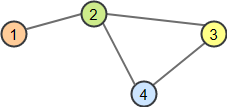

In [ ]:
# Let's create its representation

node_feats = torch.arange(8, dtype=torch.float32).view(1, 4, 2)
adj_matrix = torch.Tensor([[[1, 1, 0, 0],
                            [1, 1, 1, 1],
                            [0, 1, 1, 1],
                            [0, 1, 1, 1]]])

print("Node features:\n", node_feats)
print("\nAdjacency matrix:\n", adj_matrix)

Node features:
 tensor([[[0., 1.],
         [2., 3.],
         [4., 5.],
         [6., 7.]]])

Adjacency matrix:
 tensor([[[1., 1., 0., 0.],
         [1., 1., 1., 1.],
         [0., 1., 1., 1.],
         [0., 1., 1., 1.]]])


In [ ]:
import numpy as np

device = 'cpu'

layer = GATLayer(2, 4, num_heads=4)
# layer.projection.weight.data = torch.Tensor([[1., 0.], [0., 1.]])
# layer.projection.bias.data = torch.Tensor([0., 0.])
# layer.a.data = torch.Tensor([[-0.2, 0.3], [0.1, -0.1]])

with torch.no_grad():
    out_feats = layer(node_feats, adj_matrix, print_attn_probs=True)

print("Adjacency matrix", adj_matrix)
print("Input features", node_feats)
print("Output features", out_feats)

Attention probs
 tensor([[[[0.5072, 0.4928, 0.0000, 0.0000],
          [0.2558, 0.2485, 0.2478, 0.2478],
          [0.0000, 0.3340, 0.3330, 0.3330],
          [0.0000, 0.3340, 0.3330, 0.3330]],

         [[0.6774, 0.3226, 0.0000, 0.0000],
          [0.3155, 0.2315, 0.2265, 0.2264],
          [0.0000, 0.3383, 0.3310, 0.3308],
          [0.0000, 0.3383, 0.3310, 0.3308]],

         [[0.2709, 0.7291, 0.0000, 0.0000],
          [0.2142, 0.2611, 0.2635, 0.2612],
          [0.0000, 0.3323, 0.3353, 0.3324],
          [0.0000, 0.3323, 0.3353, 0.3324]],

         [[0.5011, 0.4989, 0.0000, 0.0000],
          [0.2500, 0.2490, 0.2495, 0.2515],
          [0.0000, 0.3320, 0.3327, 0.3354],
          [0.0000, 0.3320, 0.3327, 0.3354]]]])
Adjacency matrix tensor([[[1., 1., 0., 0.],
         [1., 1., 1., 1.],
         [0., 1., 1., 1.],
         [0., 1., 1., 1.]]])
Input features tensor([[[0., 1.],
         [2., 3.],
         [4., 5.],
         [6., 7.]]])
Output features tensor([[[ 0.7705, -0.1210, -0.579

**Task VI - Quantum Representation Learning:**



*   Load the MNIST dataset

*   Write a function which takes an image and prepares a quantum state. This function should have trainable parameters which we want to learn in order to have good quantum representations

*   Create a circuit with which takes two images and embeds both as quantum states with the function you wrote before. Afterwards the circuit should perform a SWAP test between the two states. In the end the measurement should give the fidelity of the quantum states.

*   Train the circuit parameters with a contrastive loss: For two MNIST images in the same class the fidelity should be maximized, while for images of different classes the fidelity should be minimized.



Some important notes regarding the contrastive loss: classically, it is based on the cosine distance. In our case, we aim for the fidelity - I modify the **InfoNCE loss**, specifically. Given an image pair (**query**,**positive**) or (**query**,**negative**):



*   we extract two representations from the given pair, **h1** and **h2**.
*   These are embedded into the quantum circuit showed.


*   In the end, a **SWAP test** is made between the two quantum states.
*   Since we are running on a simulator, we know the fidelity reduces to the squared inner product **|<Ψ|φ>|^2** .


*   Each qubit i measured from the SWAP test gives **P(0) = 1/2 + (1/2)*|< i | j >|^2** . So we estimate |< i | j >| as:






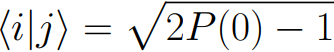

## Important: in my tests, I noticed that this leads to **numerical instabilities!** Even adding a small epsilon to the formula before taking the square root does not solve it. So, instead, the final similarity is the sum of the squares of each inner product, instead of the sum of the smaller inner products.


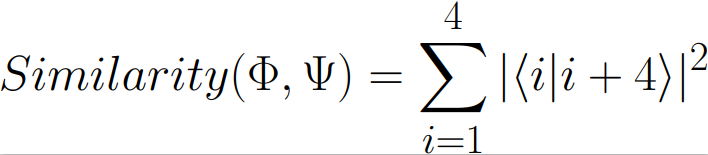

100%|██████████| 9912422/9912422 [00:00<00:00, 198747119.80it/s]


Extracting .sample_data/MNIST/raw/train-images-idx3-ubyte.gz to .sample_data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 111031800.02it/s]

Extracting .sample_data/MNIST/raw/train-labels-idx1-ubyte.gz to .sample_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 74237501.44it/s]


Extracting .sample_data/MNIST/raw/t10k-images-idx3-ubyte.gz to .sample_data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 20331407.44it/s]

Extracting .sample_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to .sample_data/MNIST/raw




INFO:lightning_fabric.utilities.seed:Global seed set to 42
INFO:lightning_fabric.utilities.seed:Global seed set to 42
/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=

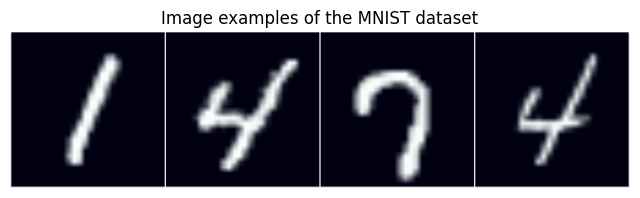

In [6]:
import os
import urllib.request
from urllib.error import HTTPError

import matplotlib
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
from IPython.display import set_matplotlib_formats
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from torchvision import transforms
from torchvision.datasets import  MNIST

test_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize((224, 224)),
        transforms.Lambda(lambda x: x.repeat(3,1,1)),
        transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784]),
    ]
)
# For training, we add some augmentation. Networks are too powerful and would overfit.
train_transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3,1,1)),
        transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784]),
    ]
)


# Loading the training dataset. We need to split it into a training and validation part
# We need to do a little trick because the validation set should not use the augmentation.
train_dataset = MNIST(root=".sample_data", train=True, transform=train_transform, download=True)
val_dataset = MNIST(root=".sample_data", train=True, transform=test_transform, download=True)
pl.seed_everything(42)
train_set, _ = torch.utils.data.random_split(train_dataset, [55000, 5000])
pl.seed_everything(42)
_, val_set = torch.utils.data.random_split(val_dataset, [55000, 5000])

# Loading the test set
test_set = MNIST(root=".sample_data", train=False, transform=test_transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
train_loader = data.DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
val_loader = data.DataLoader(val_set, batch_size=128, shuffle=False, drop_last=False, num_workers=4)
test_loader = data.DataLoader(test_set, batch_size=128, shuffle=False, drop_last=False, num_workers=4)

# Visualize some examples
NUM_IMAGES = 4
MNIST_images = torch.stack([val_set[idx][0] for idx in range(NUM_IMAGES)], dim=0)
img_grid = torchvision.utils.make_grid(MNIST_images, nrow=4, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8, 8))
plt.title("Image examples of the MNIST dataset")
plt.imshow(img_grid)
plt.axis("off")
plt.show()
plt.close()

In [7]:
def H_layer(n_qubits, n_ancillas):
    for idx in range(n_ancillas, n_qubits): # 0th qubits reserved for ancilla purposes
        qml.Hadamard(idx)

def RY_layer(w, n_ancillas):
    """Layer of parametrized qubit rotations around the y axis.
    """
    for idx, element in enumerate(w, start=n_ancillas): # 1st qubit is ancilla, used for SWAP test here.
        qml.RY(element, wires=idx)


def entangling_layer(nqubits, n_ancillas):
    """Layer of CNOTs followed by another shifted layer of CNOT.
    """
    # In other words it should apply something like :
    # CNOT  CNOT  CNOT  CNOT...  CNOT
    #   CNOT  CNOT  CNOT...  CNOT
    for i in range(n_ancillas, nqubits - 1, 2):  # Loop over even indices: i=0,2,...N-2
        qml.CNOT(wires=[i, i + 1])
    for i in range(n_ancillas + 1, nqubits - 1, 2):  # Loop over odd indices:  i=1,3,...N-3
        qml.CNOT(wires=[i, i + 1])

In [8]:
import torch
import torch.nn.functional as F
from torch import nn



class InfoNCE(nn.Module):
    """
    Calculates the InfoNCE loss for self-supervised learning.
    This contrastive loss enforces the embeddings of similar (positive) samples to be close
        and those of different (negative) samples to be distant.
    A query embedding is compared with one positive key and with one or more negative keys.
    References:
        https://arxiv.org/abs/1807.03748v2
        https://arxiv.org/abs/2010.05113
    Args:
        temperature: Logits are divided by temperature before calculating the cross entropy.
        reduction: Reduction method applied to the output.
            Value must be one of ['none', 'sum', 'mean'].
            See torch.nn.functional.cross_entropy for more details about each option.
        negative_mode: Determines how the (optional) negative_keys are handled.
            Value must be one of ['paired', 'unpaired'].
            If 'paired', then each query sample is paired with a number of negative keys.
            Comparable to a triplet loss, but with multiple negatives per sample.
            If 'unpaired', then the set of negative keys are all unrelated to any positive key.
    Input shape:
        query: (N, D) Tensor with query samples (e.g. embeddings of the input).
        positive_key: (N, D) Tensor with positive samples (e.g. embeddings of augmented input).
        negative_keys (optional): Tensor with negative samples (e.g. embeddings of other inputs)
            If negative_mode = 'paired', then negative_keys is a (N, M, D) Tensor.
            If negative_mode = 'unpaired', then negative_keys is a (M, D) Tensor.
            If None, then the negative keys for a sample are the positive keys for the other samples.
    Returns:
         Value of the InfoNCE Loss.
     Examples:
        >>> loss = InfoNCE()
        >>> batch_size, num_negative, embedding_size = 32, 48, 128
        >>> query = torch.randn(batch_size, embedding_size)
        >>> positive_key = torch.randn(batch_size, embedding_size)
        >>> negative_keys = torch.randn(num_negative, embedding_size)
        >>> output = loss(query, positive_key, negative_keys)
    """

    def __init__(self, n_qubits, n_ancillas, q_depth, q_params, temperature=0.1, epsilon = 1e-4, reduction='mean', negative_mode='unpaired'):
        super().__init__()
        self.temperature = temperature
        self.reduction = reduction
        self.negative_mode = negative_mode
        
        self.n_qubits = n_qubits
        self.n_ancillas = n_ancillas
        self.q_depth = q_depth
        self.q_params = q_params
        self.epsilon = epsilon

    def forward(self, query, positive_key, negative_keys=None):
        return info_nce(query, positive_key, negative_keys,
                        temperature=self.temperature,
                        epsilon = self.epsilon,
                        reduction=self.reduction,
                        negative_mode=self.negative_mode,
                        q_params = self.q_params,
                        q_depth = self.q_depth,
                        n_qubits = self.n_qubits,
                        n_ancillas = self.n_ancillas)


def info_nce(query, positive_key, negative_keys=None, temperature=0.1, epsilon = 1e-4, reduction='mean', negative_mode='unpaired',
             q_params=None, q_depth=None, n_qubits=None, n_ancillas=None):
    
    assert q_params is not None
    assert q_depth is not None
    assert n_qubits is not None
    assert n_ancillas is not None
    
    # Check input dimensionality.
    if query.dim() != 2:
        raise ValueError('<query> must have 2 dimensions.')
    if positive_key.dim() != 2:
        raise ValueError('<positive_key> must have 2 dimensions.')
    if negative_keys is not None:
        if negative_mode == 'unpaired' and negative_keys.dim() != 2:
            raise ValueError("<negative_keys> must have 2 dimensions if <negative_mode> == 'unpaired'.")
        if negative_mode == 'paired' and negative_keys.dim() != 3:
            raise ValueError("<negative_keys> must have 3 dimensions if <negative_mode> == 'paired'.")

    # Check matching number of samples.
    if len(query) != len(positive_key):
        raise ValueError('<query> and <positive_key> must must have the same number of samples.')
    if negative_keys is not None:
        if negative_mode == 'paired' and len(query) != len(negative_keys):
            raise ValueError("If negative_mode == 'paired', then <negative_keys> must have the same number of samples as <query>.")

    # Embedding vectors should have same number of components.
    if query.shape[-1] != positive_key.shape[-1]:
        raise ValueError('Vectors of <query> and <positive_key> should have the same number of components.')
    if negative_keys is not None:
        if query.shape[-1] != negative_keys.shape[-1]:
            raise ValueError('Vectors of <query> and <negative_keys> should have the same number of components.')

    # Normalize to unit vectors
    # query, positive_key, negative_keys = normalize(query, positive_key, negative_keys)
    q_in_query = torch.tanh(query) * np.pi / 2.0
    q_in_pos = torch.tanh(positive_key) * np.pi / 2.0

    
    if negative_keys is not None:
        # Explicit negative keys
        q_in_neg = torch.tanh(negative_keys) * np.pi / 2.0
        # Cosine between positive pairs
        # should return: Tensor([[0.81], [0.009], [-1.2], ...]]) 
        # positive_logit = torch.sum(query * positive_key, dim=1, keepdim=True)
        positive_logit = torch.Tensor(0, 1)#query.shape[0])
        for h1, h2 in zip(q_in_query, q_in_pos): # CHECK THAT h1 and h2 have single dim.

            q_pair = torch.cat((h1, h2), axis=0) # hidden representations concatenated into single vector.

            similarity = embed_image(q_input_features=q_pair, q_weights_flat=q_params, q_depth=q_depth, n_qubits=n_qubits, n_ancillas=n_ancillas, train=True)

            similarity = (2*similarity - 1 + epsilon)#**0.5
            similarity = torch.sum(similarity) # = sum(<i|j>) = <q_in_1 | q_in_2 >; i,j=1...n_qubits
            similarity = similarity**2

            positive_logit = torch.cat((positive_logit, similarity.unsqueeze(0).unsqueeze(0)), 0)

            
        if negative_mode == 'unpaired':
            # Cosine between all query-negative combinations
            # should return: cosine similarity matrix
            # or: fidelity matrix.

            negative_logits = torch.Tensor(0, query.shape[0])
            for h_query in query:
                row_aux = torch.Tensor(0)
                for h_neg in negative_keys:

                    q_pair = torch.cat((h_query, h_neg), axis=0) # hidden representations concatenated into single vector.

                    similarity = embed_image(q_input_features=q_pair, q_weights_flat=q_params, q_depth=q_depth, n_qubits=n_qubits, n_ancillas=n_ancillas, train=True)
                    similarity = (2*similarity - 1 + epsilon)#**0.5
                    similarity = torch.sum(similarity) # = sum(<i|j>) = <q_in_1 | q_in_2 >; i,j=1...n_qubits
                    similarity = similarity**2

                    row_aux = torch.cat((row_aux, similarity.unsqueeze(0)), 0) # row_aux = [] -> [1.0] -> [1.0, -3.2] - > ...

                negative_logits = torch.cat((negative_logits, row_aux.unsqueeze(0)), 0)


        elif negative_mode == 'paired':
            # should return: cosine similarity matrix
            # or: fidelity matrix.

            negative_logits = torch.Tensor(0, query.shape[0])
            for idx, h_query in enumerate(query):
                row_aux = torch.Tensor(0)
                for h_neg in negative_keys[idx]:

                    q_pair = torch.cat((h_query, h_neg), axis=1) # hidden representations concatenated into single vector.

                    similarity = embed_image(q_input_features=q_pair, q_weights_flat=self.q_params, q_depth=q_depth, n_qubits=n_qubits, n_ancillas=n_ancillas, train=True)
                    similarity = (2*similarity - 1 + epsilon)#**0.5
                    similarity = torch.sum(similarity) # = sum(<i|j>) = <q_in_1 | q_in_2 >; i,j=1...n_qubits
                    similarity = similarity**2

                    row_aux = torch.cat((row_aux, similarity.unsqueeze(0)), 0) # row_aux = [] -> [1.0] -> [1.0, -3.2] - > ...

                negative_logits = torch.cat((negative_logits, row_aux.unsqueeze(0)), 0)

        # First index in last dimension are the positive samples
        logits = torch.cat([positive_logit, negative_logits], dim=1)
        labels = torch.zeros(len(logits), dtype=torch.long, device=query.device)
    else:
        # Negative keys are implicitly off-diagonal positive keys.

        # Cosine between all combinations
        # should return: cosine similarity matrix
        # or: fidelity matrix.
        # logits = query @ transpose(positive_key)

        # print("SHAPES QUERY: {}\nSHAPES POSITIVE KEY: {}".format(query.shape, positive_key.shape))
        logits = torch.Tensor(0, query.shape[0])
        for h_query in query:
            row_aux = torch.Tensor(0)
            for h_pos in positive_key:
                q_pair = torch.cat((h_query, h_pos), axis=0) # hidden representations concatenated into single vector.

                similarity = embed_image(q_input_features=q_pair, q_weights_flat=q_params, q_depth=q_depth, n_qubits=n_qubits, n_ancillas=n_ancillas, train=True)
                similarity = (2*similarity - 1 + epsilon)#**0.5
                similarity = torch.sum(similarity) # = sum(<i|j>) = <q_in_1 | q_in_2 >; i,j=1...n_qubits
                similarity = similarity**2

                row_aux = torch.cat((row_aux, similarity.unsqueeze(0)), 0) # row_aux = [] -> [1.0] -> [1.0, -3.2] - > ...
                
            logits = torch.cat((logits, row_aux.unsqueeze(0)), 0)

        # Positive keys are the entries on the diagonal
        labels = torch.arange(len(query), device=query.device)

    return F.cross_entropy(logits / temperature, labels, reduction=reduction)

In [9]:
import pennylane as qml

dev = qml.device("default.qubit", wires=12)


@qml.qnode(dev, interface="torch")
def embed_image(q_input_features, q_weights_flat, q_depth, n_qubits, n_ancillas, train=False):
    """
    The variational quantum circuit. It takes the image hidden representation
    and prepares a quantum state using trainable parameters.

    Given 2 images, they go through a classical resnet, which in the end gives a classical feature vector of dim = (n_qubits = 4 in this example).
        - Image 1 is then encoded in a Parametrized Quantum Circuit (PQC), giving the state |Ψ>.
        - Image 2 is then encoded in the same Parametrized Quantum Circuit (PQC), giving the state |φ>.
    We have then proceed to define a PQC consisting of 3*n_qubits, that is:
        - n_qubits as ancilliary ones.
        - n qubits for the first image.
        - n qubits for the second image.
    In the end, through a CSAWP test, we estimate the inner product <Ψ|φ>. More specifically, we estimate |<Ψ|φ>|^2, which is
    the fidelity measure for pure states.

    If train == True, then it performs a SWAP test, returning the fidelity in the end. Else, it return the measurements in the Z basis.
    """

    # Reshape weights
    q_weights = q_weights_flat.reshape(q_depth, n_qubits - 4)

    # Start from state |+> , unbiased w.r.t. |0> and |1>
    H_layer(n_qubits, n_ancillas)

    # Embed features in the quantum node
    RY_layer(q_input_features, n_ancillas)

    # Sequence of trainable variational layers
    for k in range(q_depth):
        entangling_layer(n_qubits, n_ancillas)
        RY_layer(q_weights[k], n_ancillas)

    if train == False:
        # Expectation values in the Z basis
        exp_vals = [qml.expval(qml.PauliZ(position)) for position in range(n_ancillas, n_qubits)]
        return tuple(exp_vals)

    else: # performs SWAP test & returns fidelity estimate.
        
        for idx in range(n_ancillas):
            qml.Hadamard(idx)
            qml.CSWAP(wires = [idx, idx + n_ancillas, idx + 2*n_ancillas])
            qml.Hadamard(idx)

        # exp = qml.probs(wires=[0]) #qml.expval(qml.PauliZ(0)) # expected value of ancilla qubit (0-th qubit)

        # P(0) = 1/2 + (1/2)*|<psi|phi>|^2

        # s = 2*exp - 1 # s is the estimate of the inner product |<psi|phi>|^2, also the fidelity
        
        exp_vals = [qml.expval(qml.PauliZ(position)) for position in range(n_ancillas)]

        return tuple(exp_vals) #qml.expval(qml.PauliZ(0)) #expval

In [10]:
import torch
import numpy as np
from torch import nn

class QuantumFidelityNet(nn.Module): # Hybrid NN trained on contrastive learning using fidelity as measure of similarity.
    """
    Torch module implementing the *dressed* quantum net.
    """

    def __init__(self, classical_net, n_qubits, q_depth = 1, q_delta=0.001, negative_mode='unpaired'):
        """
        Definition of the *dressed* layout.

        Attention: n_qubits includes the ancillas !!!
        """

        super().__init__()
        self.n_qubits = n_qubits
        self.n_ancillas = int(n_qubits / 3)
        self.q_depth = q_depth
        self.q_params = nn.Parameter(q_delta * torch.randn(q_depth * (n_qubits - self.n_ancillas) ))

        self.classical_net = classical_net
        self.loss = InfoNCE(self.n_qubits, self.n_ancillas, 
                            self.q_depth, self.q_params,
                            epsilon = 0,
                            negative_mode='unpaired')

        for param in self.classical_net.parameters():
            param.requires_grad = False

        self.classical_net.fc = nn.Linear(512, (self.n_qubits -  self.n_ancillas)// 2)

        # showscase our PQC
        print(qml.draw(embed_image)(q_input_features=torch.rand(8), q_weights_flat=self.q_params, q_depth=self.q_depth, n_qubits=self.n_qubits, n_ancillas=self.n_ancillas, train=True))

    def forward(self, query, positives, negatives = None, train=False):

        """
        Given 2 images, they go through a classical resnet, which in the end gives a classical feature vector of dim = (n_qubits = 4 in this example).
            - Image 1 is then encoded in a Parametrized Quantum Circuit (PQC), giving the state |Ψ>.
            - Image 2 is then encoded in a Parametrized Quantum Circuit (PQC), giving the state |φ>.
        We have then proceed to define a PQC consisting of 2*n_qubits + 1, that is:
            - 1 ancilliary qubit.
            - n qubits for the first image.
            - n qubits for the second image.
        In the end, through a CSAWP test, we estimate the inner product <Ψ|φ>. More specifically, we estimate |<Ψ|φ>|^2, which is
        the fidelity measure for pure states.
        """

        repr_1 = self.classical_net(query) # [B, n_qubits] : (batch_size, n_qubits)
        if negatives is not None and train == True:
            repr_2 = self.classical_net(positives) 
            repr_3 = self.classical_net(negatives) 
            return self.loss(repr_1, repr_2, repr_3)
        else:
            repr_2 = self.classical_net(positives) 
            return self.loss(repr_1, repr_2)

        return embed_image(q_input_features=repr_1, q_weights_flat=self.q_params, q_depth=self.q_depth, n_qubits=self.n_qubits, n_ancillas=self.n_ancillas, train=train)
        
        # q_in_1 = torch.tanh(repr_1) * np.pi / 2.0
        # q_in_2 = torch.tanh(repr_2) * np.pi / 2.0

        # q_in = torch.cat((q_in_1, q_in_2), axis=0)


        # print("Shape after classical net: {}".format(q_in_1.shape))

        # # print("|Ψ>: {}\n|φ>: {}\n<φ|Ψ>: {}".format(q_in_1, q_in_2, q_in_1@q_in_2.T))

        # print(qml.draw(embed_image)(q_input_features=q_in[0], q_weights_flat=self.q_params, q_depth=self.q_depth, n_qubits=self.n_qubits, n_ancillas=self.n_ancillas, train=train))
        # similarity = embed_image(q_input_features=q_in[0], q_weights_flat=self.q_params, q_depth=self.q_depth, n_qubits=self.n_qubits, n_ancillas=self.n_ancillas, train=train) #.float().unesqueeze(0)
        # similarity = (2*similarity - 1)**0.5
        # similarity = torch.sum(similarity) # = sum(<i|j>) = <q_in_1 | q_in_2 >; i,j=1...n_qubits

        # return similarity**2 # fidelity

        # return self.loss(repr_1, repr_2)

# Let's define a dataset of triplets for MNIST:

In [10]:
def generate_pairs(dataset, max_size = None):
    """
    Creates a collection of positive and negative image pairs from the supplied
    array of images.

    A positive pair contains two images of the same digit. A negative pair contains
    two images representing different digits.
    """

    x_triplets = []

    for i in range(len(dataset)):

        label = dataset[i][1]

        complete = [False, False]
        aux = [dataset[i][0]]
        for j in range(len(dataset)):
            if dataset[j][1] == label and complete[1] == False:
                aux.append(dataset[j][0])
                complete[1] = True
            elif dataset[j][1] != label and complete[0] == False:
                aux.append(dataset[j][0])
                complete[0] = True

            if complete[0] == True and complete[1] == True:
                break

        x_triplets.append(torch.stack(aux))

        
        if max_size != None and i >= max_size:
            break


    return torch.stack(x_triplets)

In [11]:
train_triplets_tensor = generate_pairs(train_dataset, max_size = 128)
val_triplets_tensor = generate_pairs(val_dataset, max_size = 32)
test_triplets_tensor = generate_pairs(test_set, max_size = 32)

In [12]:
from torch.utils.data import Dataset, DataLoader

class MNISTTripletsDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, triplets_tensor):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.triplets_tensor = triplets_tensor

    def __len__(self):
        return len(self.triplets_tensor)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        sample = {'query': self.triplets_tensor[idx, 0], 'positive': self.triplets_tensor[idx, 1], 'negative': self.triplets_tensor[idx, 2]}

        return sample

In [13]:
train_triplets_dataset = MNISTTripletsDataset(train_triplets_tensor)

In [14]:
val_triplets_dataset = MNISTTripletsDataset(val_triplets_tensor)

In [15]:
test_triplets_dataset = MNISTTripletsDataset(test_triplets_tensor)

# **Declare the classical net**

In [11]:
import torchvision

classical_net = torchvision.models.resnet18(pretrained=True)


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 122MB/s] 


# Let's create our QuantumFidelityNet and see how our PQC looks like:

In [12]:
qfn = QuantumFidelityNet(classical_net, n_qubits = 12, q_depth=1, q_delta=0.001)

 0: ──H───────────────────────────────────╭●─────H────────────────────────────┤  <Z>
 1: ──────────────────────────────────────│──────H─╭●─────H───────────────────┤  <Z>
 2: ──────────────────────────────────────│────────│──────H─╭●─────H──────────┤  <Z>
 3: ──────────────────────────────────────│────────│────────│──────H─╭●─────H─┤  <Z>
 4: ──H──RY(0.63)─╭●──RY(0.00)────────────├SWAP────│────────│────────│────────┤     
 5: ──H──RY(0.11)─╰X─╭●─────────RY(-0.00)─│────────├SWAP────│────────│────────┤     
 6: ──H──RY(0.51)─╭●─╰X─────────RY(0.00)──│────────│────────├SWAP────│────────┤     
 7: ──H──RY(0.40)─╰X─╭●─────────RY(0.00)──│────────│────────│────────├SWAP────┤     
 8: ──H──RY(0.18)─╭●─╰X─────────RY(-0.00)─╰SWAP────│────────│────────│────────┤     
 9: ──H──RY(0.64)─╰X─╭●─────────RY(-0.00)──────────╰SWAP────│────────│────────┤     
10: ──H──RY(0.54)─╭●─╰X─────────RY(-0.00)───────────────────╰SWAP────│────────┤     
11: ──H──RY(0.35)─╰X──RY(0.00)───────────────────────────────────

In [18]:
def train_one_epoch():
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for batch_idx in range(len(train_triplets_dataset)):
        # Every data instance is an input + label pair
        # inputs, labels = data

        if (batch_idx + 1) * 16 >= len(train_triplets_dataset):
            data_idx = [i for i in range(batch_idx*16, len(train_triplets_dataset) - 1)]
        else:
            data_idx = [i for i in range(batch_idx*16, (batch_idx + 1)*16)]

        if len(data_idx) == 0:
            break


        query = train_triplets_dataset[data_idx]["query"]
        pos = train_triplets_dataset[data_idx]["positive"]
        neg = train_triplets_dataset[data_idx]["negative"]

        
        # Zero the gradients for every batch!
        optimizer.zero_grad()

        loss = qfn(query, pos, neg, train=True)
        loss.backward()
        
        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        last_loss = running_loss / 1000 # loss per batch
        print('  batch {} loss: {}'.format(batch_idx + 1, last_loss))
        running_loss = 0.

    return last_loss

In [19]:
# Optimizers specified in the torch.optim package
optimizer = torch.optim.SGD(qfn.parameters(), lr=0.001, momentum=0.9)

## Let's see the training convergence:

In [ ]:
for epoch in range(10):
    print("=================== EPOCH {} ====================".format(epoch + 1))
    train_one_epoch()

=================== EPOCH 1 ====================
  batch 1 loss: 0.06422137579264132
  batch 2 loss: 0.015061427396595054
  batch 3 loss: 0.0008624591649782367
  batch 4 loss: 0.00012838049341382777
  batch 5 loss: 4.979787530659902e-10
  batch 6 loss: 2.3412454275018166e-07
  batch 7 loss: 0.0024345254437963884
  batch 8 loss: 1.3433659414463038e-08
=================== EPOCH 2 ====================
  batch 1 loss: 5.5943943800046204e-11
  batch 2 loss: 5.3711367309493674e-09


**Task VII - Equivariant quantum neural networks:**



*   Generate a classification dataset with two classes and two features x_1 and x_2 which respects the Z_2 x Z_2 symmetry (this corresponds to mirroring along y=x). An example can be found in the first reference paper.

*   Train a QNN to solve the classification problem

*   Train an Z_2 x Z_2 equivariant QNN to solve the classification problem and compare the results.



In [ ]:
X = np.random.randn(50, 2)
X += X.take([1,0], axis = 1)
X = np.concatenate((X, X.take([1,0], axis=1 ) ) )

In [ ]:
Y = []
for vector in X:
    if vector[1] >= vector[0]:
        Y.append(1)
    else:
        Y.append(0)

In [ ]:
# calculate the mean square error for this classification problem
def cost_function(params, input, target):
    output = torch.stack([circuit(x, params) for x in input])
    vec = output - target
    sum_sqr = torch.sum(vec * vec, dim=1)
    return torch.mean(sum_sqr)

In [ ]:
from torch import optim
import numpy as np

params = 0.01 * torch.randn(9)
params.requires_grad = True
opt = optim.Adam([params], lr=1e-2)


max_epoch = 15
max_step = 30
batch_size = 10

encoded_dataset = list(zip(*[encode_game(game) for game in dataset]))
encoded_dataset_val = list(zip(*[encode_game(game) for game in dataset_val]))


def accuracy(p, x_val, y_val):
    with torch.no_grad():
        y_val = torch.tensor(y_val)
        y_out = torch.stack([circuit(x, p) for x in x_val])
        acc = torch.sum(torch.argmax(y_out, axis=1) == torch.argmax(y_val, axis=1))
        return acc / len(x_val)


print(f"accuracy without training = {accuracy(params, *encoded_dataset_val)}")

x_dataset = torch.stack(encoded_dataset[0])
y_dataset = torch.tensor(encoded_dataset[1], requires_grad=False)

saved_costs_sym = []
saved_accs_sym = []
for epoch in range(max_epoch):
    rand_idx = torch.randperm(len(x_dataset))
    # Shuffled dataset
    x_dataset = x_dataset[rand_idx]
    y_dataset = y_dataset[rand_idx]

    costs = []

    for step in range(max_step):
        x_batch = x_dataset[step * batch_size : (step + 1) * batch_size]
        y_batch = y_dataset[step * batch_size : (step + 1) * batch_size]

        def opt_func():
            opt.zero_grad()
            loss = cost_function(params, x_batch, y_batch)
            costs.append(loss.item())
            loss.backward()
            return loss

        opt.step(opt_func)

    cost = np.mean(costs)
    saved_costs_sym.append(cost)

    if (epoch + 1) % 1 == 0:
        # Compute validation accuracy
        acc_val = accuracy(params, *encoded_dataset_val)
        saved_accs_sym.append(acc_val)

        res = [epoch + 1, cost, acc_val]
        print("Epoch: {:2d} | Loss: {:3f} | Validation accuracy: {:3f}".format(*res))

**Task VIII: Vision transformer/Quantum Vision Transformer**

In [ ]:
# https://arxiv.org/pdf/2209.08167.pdf

In [ ]:
# https://github.com/lucidrains/vit-pytorch

# we could change:
#    - mlp to variational circuit.
#    - Quantum Attention Mechanism.